# Predictive Analytics

To get a better understanding of the dynamics in the field of ride-hailing in Chicago, we want to employ Neural Networks to predict the taxi demand in spatio-temporal resolution.
This notebook is structured as follows:
* Import necessary python libraries and files
* Construction of the final feature sets
* Predictive Analytics

Since we use large datasets it could appear that we run into some memory issues. Therefore, we designed this notebook in a way, that the feature set construction and the predictive analytics could be run independently from one another. For that, the saved files from the first part will be imported again at the beginning of the second part.

**Important note:** The first two parts "Import files" and "Construction of the final feature sets" can only be run if the previous notebooks ran to completion or if the trips_2013_extended.pkl file is added manually to the data folder because the file is too large for the git repository. The part "Predictive Analytics" can be run with the files that are located in the git repository.

### Import libraries

In [ ]:
# Import necessary libraries
import pandas as pd
from google.colab import drive
import pickle

import gc

import warnings
warnings.filterwarnings('ignore')

### Import files

First, we need to import the Chicago taxi trip dataset from 2013. The extended trips dataset, that was created in the Feature Engineering notebook, contains all relevant features, that we will use/try out in the prediction.

In [ ]:
# Import necessary pickle datasets after preprocessing
# Mount Google Drive
drive.mount('/content/drive')

# Path to the pickle files and CSV file in Google Drive
trips_2013_pickle_path = '/content/drive/MyDrive/TME/Data/trips_2013_extended.pkl'

# Load the pickle files into Pandas DataFrames
with open(trips_2013_pickle_path, 'rb') as file:
    trips_2013 = pickle.load(file)

# Ensure 'start_time' is in datetime format
if not pd.api.types.is_datetime64_any_dtype(trips_2013['start_time']):
    trips_2013['start_time'] = pd.to_datetime(trips_2013['start_time'])

# Preview the DataFrames
trips_2013.head()

Mounted at /content/drive


,trip_id,taxi_id,start_time,end_time,duration,distance,start_location,start_lat,start_long,end_location,...,is_special_date,is_holiday,hour,day,week_day,part_of_day,is_weekend,month,cost_per_minute,cost_per_km
0,3e9d8cc29f55f4f2b35b48cf912c023b7531fc40,a29bd1a1911d3e1c9d1493ded2b6ffc5bb87dd64944020...,2013-01-01,2013-01-01 00:15:00,720.0,4.184294,POINT (-87.6515625922 41.9363101308),41.936310,-87.651563,POINT (-87.6638654956 41.9726679555),...,0,1,0,2013-01-01,1,Early Morning,0,1,0.013125,2.258445
1,0f63007e437d589c9139acb026f03a832da3240f,0aeba5363032eea4da934ccd44dde715dce7305a792531...,2013-01-01,2013-01-01 00:15:00,480.0,2.414016,POINT (-87.6515625922 41.9363101308),41.936310,-87.651563,POINT (-87.6453787624 41.962178629),...,0,1,0,2013-01-01,1,Early Morning,0,1,0.013854,2.754746
2,2330f00083ab438db5839d3949fff9954513cb77,1eaef5df745de5ff990139aa7cce76faffa732d4579cac...,2013-01-01,2013-01-01 00:15:00,540.0,3.057754,POINT (-87.6711095263 41.9724370811),41.972437,-87.671110,POINT (-87.683718102 41.957735565),...,0,1,0,2013-01-01,1,Early Morning,0,1,0.014167,2.501837
3,cc83914c6a72d6f861d5be744332d41e120dfdca,325a58f0fa1e439b2b733651dac2847dab175253ed4652...,2013-01-01,2013-01-01 00:15:00,240.0,1.126541,POINT (-87.6318639497 41.8920421365),41.892042,-87.631864,POINT (-87.6378442095 41.8932163595),...,0,1,0,2013-01-01,1,Early Morning,0,1,0.020208,4.305215
4,dc843ad6e036c84b081368998db84227d47e159c,1a30531bb84733fd77ff82bc683753286ceedaae406d2b...,2013-01-01,2013-01-01 00:15:00,600.0,2.574950,POINT (-87.6317173661 41.9146162864),41.914616,-87.631717,POINT (-87.6428084655 41.8853000224),...,0,1,0,2013-01-01,1,Early Morning,0,1,0.015083,3.514631


In [ ]:
trips_2013.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448673 entries, 0 to 6448672
Data columns (total 34 columns):
 #   Column              Dtype         
---  ------              -----         
 0   trip_id             object        
 1   taxi_id             object        
 2   start_time          datetime64[ns]
 3   end_time            datetime64[ns]
 4   duration            float64       
 5   distance            float64       
 6   start_location      object        
 7   start_lat           float64       
 8   start_long          float64       
 9   end_location        object        
 10  end_lat             float64       
 11  end_long            float64       
 12  start_census_tract  int64         
 13  end_census_tract    int64         
 14  company             object        
 15  payment_type        object        
 16  fare                float64       
 17  extras              float64       
 18  tips                float64       
 19  tolls               float64       
 20  tr

### Construction of the final feature sets

As a basis for the construction of the final feature set, we want to extract the date related features that we will try for the prediction. The columns, that we **initially** used from the trips dataset, were: start_census_tract, day, hour, week_day, month, poi_count_start, airport_trip, is_holiday, is_special_date.

Finally, we construct the feature sets for the four temporal resoulutions (hourly, two-hourly, six-hourly, and daily). Since we will have to create 4 sets we will use the function below to create feature sets based on different time buckets

In [ ]:
# Function to create feature sets based on different time buckets
def create_feature_set(df, group_by_cols, additional_cols=[]):
    """
    Groups the DataFrame by specified columns and counts the number of trips.

    Parameters:
    - df: Pandas DataFrame
    - group_by_cols: List of columns to group by
    - additional_cols: List of additional columns to retain (using the first occurrence)

    Returns:
    - Aggregated feature set as a Pandas DataFrame
    """
    agg_dict = { 'trip_id': 'count' }  # Counting trips
    for col in additional_cols:
        agg_dict[col] = 'first'  # Retaining the first occurrence of additional columns
    feature_set = df.groupby(group_by_cols).agg(agg_dict).reset_index()
    feature_set = feature_set.rename(columns={'trip_id': 'trips'})  # Renaming for clarity
    return feature_set

#### Hourly Feature Sets

We decided to represent the taxi demand as the total number of trips for a given temporal resolution.

For the hourly feature set we group the dataframe by the columns cesus tract, day, and hour to then calculate the number of total trips.

In [ ]:
# Create a new column for the hour
trips_hourly = trips_2013.copy()
trips_hourly['hour'] = trips_hourly['start_time'].dt.hour

# Define grouping columns and additional columns to retain
group_by_hourly = ['start_census_tract', 'day', 'hour']
additional_cols_hourly = ['week_day', 'month', 'poi_count_start', 'airport_trip',
                          'is_holiday', 'is_special_date']

# Create the hourly feature set
feature_set_hourly_ct = create_feature_set(trips_hourly, group_by_hourly, additional_cols_hourly)

# Verify the sum of trips
hourly_total = feature_set_hourly_ct['trips'].sum()
print(f"Hourly Trips Sum: {hourly_total}")

feature_set_hourly_ct.head(5)

Hourly Trips Sum: 6448673


,start_census_tract,day,hour,trips,week_day,month,poi_count_start,airport_trip,is_holiday,is_special_date
0,17031010100,2013-04-21,1,1,6,4,0.0,0,0,0
1,17031010100,2013-12-06,19,1,4,12,0.0,0,0,0
2,17031010201,2013-02-16,19,1,5,2,1.0,0,0,0
3,17031010201,2013-03-01,6,1,4,3,1.0,0,0,0
4,17031010201,2013-03-01,20,1,4,3,1.0,0,0,0


In [ ]:
# Save hourly feature set as pickle
# Path to the directory on Google Drive
drive_path = '/content/drive/MyDrive/TME/Data/'

# Define the path
feature_set_hourly_ct_path = f'{drive_path}feature_set_hourly_ct.pkl'

# Save feature set as a Pickle file
with open(feature_set_hourly_ct_path, 'wb') as file:
    pickle.dump(feature_set_hourly_ct, file)

In [ ]:
# Clear variables
del feature_set_hourly_ct, trips_hourly

#### 2-hourly Feature Sets

For the two-hourly feature sets we apply the steps from above. However, we have to map the hours to two-hour intervals.

In [ ]:
# Create a new column for the two-hour interval
trips_2hourly = trips_2013.copy()
trips_2hourly['two_hour_interval'] = trips_2hourly['start_time'].dt.hour // 2

# Define grouping columns and additional columns to retain
group_by_2hourly = ['start_census_tract', 'day', 'two_hour_interval']
additional_cols_2hourly = ['week_day', 'month', 'poi_count_start', 'airport_trip',
                           'is_holiday', 'is_special_date']

# Create the two-hourly feature set
feature_set_2hourly_ct = create_feature_set(trips_2hourly, group_by_2hourly, additional_cols_2hourly)
feature_set_2hourly_ct.rename(columns={'two_hour_interval': 'hour'}, inplace=True)

# Verify the sum of trips
two_hourly_total = feature_set_2hourly_ct['trips'].sum()
print(f"Two-Hourly Trips Sum: {two_hourly_total}")

feature_set_2hourly_ct.head(5)

Two-Hourly Trips Sum: 6448673


,start_census_tract,day,hour,trips,week_day,month,poi_count_start,airport_trip,is_holiday,is_special_date
0,17031010100,2013-04-21,0,1,6,4,0.0,0,0,0
1,17031010100,2013-12-06,9,1,4,12,0.0,0,0,0
2,17031010201,2013-02-16,9,1,5,2,1.0,0,0,0
3,17031010201,2013-03-01,3,1,4,3,1.0,0,0,0
4,17031010201,2013-03-01,10,1,4,3,1.0,0,0,0


In [ ]:
# Save two-hourly feature set as pickle

# Define the path
feature_set_2hourly_ct_path = f'{drive_path}feature_set_2hourly_ct.pkl'

# Save feature set as a Pickle file
with open(feature_set_2hourly_ct_path, 'wb') as file:
    pickle.dump(feature_set_2hourly_ct, file)


In [ ]:
# Clear variables
del feature_set_2hourly_ct, trips_2hourly
gc.collect()

0

#### 6-hourly Feature Sets

Now we repeat the same steps from before to get the six-hour interval feature sets.

In [ ]:
# Create a new column for the six-hour interval
trips_6hourly = trips_2013.copy()
trips_6hourly['six_hour_interval'] = trips_6hourly['start_time'].dt.hour // 6

# Define grouping columns and additional columns to retain
group_by_6hourly = ['start_census_tract', 'day', 'six_hour_interval']
additional_cols_6hourly = ['week_day', 'month', 'poi_count_start', 'airport_trip',
                           'is_holiday', 'is_special_date']

# Create the six-hourly feature set
feature_set_6hourly_ct = create_feature_set(trips_6hourly, group_by_6hourly, additional_cols_6hourly)
feature_set_6hourly_ct.rename(columns={'six_hour_interval': 'hour'}, inplace=True)

# Verify the sum of trips
six_hourly_total = feature_set_6hourly_ct['trips'].sum()
print(f"Six-Hourly Trips Sum: {six_hourly_total}")

feature_set_6hourly_ct.head(5)

Six-Hourly Trips Sum: 6448673


,start_census_tract,day,hour,trips,week_day,month,poi_count_start,airport_trip,is_holiday,is_special_date
0,17031010100,2013-04-21,0,1,6,4,0.0,0,0,0
1,17031010100,2013-12-06,3,1,4,12,0.0,0,0,0
2,17031010201,2013-02-16,3,1,5,2,1.0,0,0,0
3,17031010201,2013-03-01,1,1,4,3,1.0,0,0,0
4,17031010201,2013-03-01,3,1,4,3,1.0,0,0,0


In [ ]:
# Save six-hourly feature sets as pickle

# Define the path
feature_set_6hourly_ct_path = f'{drive_path}feature_set_6hourly_ct.pkl'

# Save feature set as a Pickle file
with open(feature_set_6hourly_ct_path, 'wb') as file:
    pickle.dump(feature_set_6hourly_ct, file)


In [ ]:
# Clear variables
del feature_set_6hourly_ct, trips_6hourly
gc.collect()

26

#### 24-hourly/daily Feature Sets
and again ...

In [ ]:
# Create a new column for the day
trips_daily = trips_2013.copy()
trips_daily['day_bucket'] = trips_daily['start_time'].dt.date

# Define grouping columns and additional columns to retain
group_by_daily = ['start_census_tract', 'day_bucket']
additional_cols_daily = ['week_day', 'month', 'poi_count_start', 'airport_trip',
                         'is_holiday', 'is_special_date']

# Create the daily feature set
feature_set_daily_ct = create_feature_set(trips_daily, group_by_daily, additional_cols_daily)
feature_set_daily_ct.rename(columns={'day_bucket': 'day'}, inplace=True)

# Verify the sum of trips
daily_total = feature_set_daily_ct['trips'].sum()
print(f"Daily Trips Sum: {daily_total}")

feature_set_daily_ct.head(5)

Daily Trips Sum: 6448673


,start_census_tract,day,trips,week_day,month,poi_count_start,airport_trip,is_holiday,is_special_date
0,17031010100,2013-04-21,1,6,4,0.0,0,0,0
1,17031010100,2013-12-06,1,4,12,0.0,0,0,0
2,17031010201,2013-02-16,1,5,2,1.0,0,0,0
3,17031010201,2013-03-01,2,4,3,1.0,0,0,0
4,17031010201,2013-06-14,2,4,6,1.0,0,0,0


In [ ]:
# Save 24-hourly/daily feature sets as pickle

# Define the path for pickle file
feature_set_daily_ct_path = f'{drive_path}feature_set_daily_ct.pkl'

# Save each feature set as a Pickle file using the explicit `with open()` approach
with open(feature_set_daily_ct_path, 'wb') as file:
    pickle.dump(feature_set_daily_ct, file)


In [ ]:
# Clear variables
del feature_set_daily_ct, trips_daily
gc.collect()

57

# Predictive Analytics for Chicago Taxi Demand

In this notebook, we aim to predict taxi demand in Chicago using Neural Networks. We will utilize hourly, two-hourly, six hourly and daily datasets, applying feature sets based on Census Tracts. Our evaluation metrics include R² Scores, Mean Squared Errors (MSE), and Mean Absolute Errors (MAE) to assess model performance.

## 1. Import Necessary Libraries
First, we need to import all the necessary libraries required for data manipulation, model building, and evaluation.

In [1]:
# Install SciKeras if not already installed
!pip install scikeras

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Data manipulation libraries
import pandas as pd
import numpy as np
import pickle
import gc  # Garbage collector to free up memory

# Scikit-learn for model selection, preprocessing, and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# SciKeras wrapper for Keras models
from scikeras.wrappers import KerasRegressor

# TensorFlow Keras for building neural network models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

## 2. Defining Helper Functions

Before diving into data processing and model training, we'll define several helper functions. These functions will streamline the workflow by handling tasks such as data splitting, model building, hyperparameter tuning, and evaluation.

### 2.1 Data Splitting and Scaling
This function splits the dataset into training and testing sets and scales the input features to enhance model performance.

In [2]:
def split_and_scale(x, y, test_size=0.3):
    """
    Splits the dataset into training and testing sets and scales the input features.

    Parameters:
    - x (pd.DataFrame or np.ndarray): Feature set.
    - y (pd.Series or np.ndarray): Target variable.
    - test_size (float, optional): Proportion of the dataset to include in the test split. Defaults to 0.3.

    Returns:
    - x_train_scaled (np.ndarray): Scaled training features.
    - y_train (np.ndarray): Training target variable.
    - x_test_scaled (np.ndarray): Scaled testing features.
    - y_test (np.ndarray): Testing target variable.
    - scaler: Scaler used for feature scaling.
    """
    # Split into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=test_size, random_state=42
    )

    # Initialize the scaler
    scaler = StandardScaler()

    # Fit and transform the training data
    x_train_scaled = scaler.fit_transform(x_train)

    # Transform the testing data
    x_test_scaled = scaler.transform(x_test)

    return x_train_scaled, y_train, x_test_scaled, y_test, scaler


### 2.2 Building the Neural Network Model
This function constructs and compiles a Keras Sequential model based on provided hyperparameters.

In [3]:
def build_model(
    input_shape,
    optimizer='rmsprop',
    learning_rate=0.01,
    neurons=256,
    activation='relu',
    hidden_layers=1,
    **kwargs  # Accept additional keyword arguments
):
    """
    Builds and compiles a Keras Sequential model.

    Parameters:
    - input_shape (tuple): Shape of the input data (excluding batch size).
    - optimizer (str): Optimizer to use ('rmsprop', 'adam', 'sgd').
    - learning_rate (float): Learning rate for the optimizer.
    - neurons (int): Number of neurons in each Dense layer.
    - activation (str): Activation function for the Dense layers.
    - hidden_layers (int): Number of hidden Dense layers.
    - **kwargs: Additional keyword arguments.

    Returns:
    - model (tf.keras.Model): Compiled Keras model.
    """
    model = Sequential()

    # Input Layer
    model.add(Dense(neurons, activation=activation, input_shape=input_shape))

    # Hidden Layers
    for _ in range(hidden_layers):
        model.add(Dense(neurons, activation=activation))

    # Output Layer
    model.add(Dense(1))  # Single output for regression

    # Optimizer Configuration
    if optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")

    # Compile the model
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])

    return model


### 2.3 Hyperparameter Grid Search
This function performs a grid search to identify the best hyperparameters for the neural network model.

In [4]:
def grid_search_DL(x_train_scaled, y_train, build_model, param_grid=None, batch_size=512, verbose=0):
    """
    Performs grid search for hyperparameter tuning of a Keras model using SciKeras.

    Parameters:
    - x_train_scaled (np.ndarray or pd.DataFrame): Scaled training features.
    - y_train (np.ndarray or pd.Series): Training target variable.
    - build_model (function): Function to build the Keras model.
    - param_grid (dict, optional): Hyperparameters to search. Defaults to a predefined grid.
    - batch_size (int, optional): Batch size for training. Defaults to 512.
    - verbose (int, optional): Verbosity level for training. Defaults to 0.

    Returns:
    - grid_result: Result of GridSearchCV containing best parameters and scores.
    """
    if param_grid is None:
        param_grid = {
            'model__optimizer': ['rmsprop', 'adam', 'sgd'],
            'model__learning_rate': [0.001, 0.01, 0.1],
            'model__neurons': [128, 256],
            'model__hidden_layers': [1, 2],
            'model__activation': ['relu', 'tanh']
        }

    # Get input shape from training data
    input_shape = (x_train_scaled.shape[1],)

    # Initialize KerasRegressor from SciKeras
    model = KerasRegressor(
        model=lambda **kwargs: build_model(input_shape=input_shape, **kwargs),  # The function to build the Keras model
        epochs=10,
        batch_size=batch_size,
        verbose=verbose
    )

    # Create GridSearchCV instance
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=3,
        verbose=1,
        n_jobs=-1  # Utilize all available CPU cores
    )

    # Fit GridSearchCV
    grid_result = grid.fit(x_train_scaled, y_train)

    # Print Best Results
    print(f"Best Score (Negative MSE): {grid_result.best_score_}")
    print(f"Best Parameters: {grid_result.best_params_}")

    # Optional: Print All Results
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, std, param in zip(means, stds, params):
        print(f"Score: {mean} (+/-{std}) with: {param}")

    return grid_result


### 2.4 Model Evaluation
This function evaluates the trained model on the test set and calculates relevant metrics.

In [5]:
from sklearn.metrics import r2_score

def evaluate_model(x_train_scaled, y_train, x_test_scaled, y_test, build_model, model_params,
                   model_prefix="model", epochs=30, verbose=0, batch_size=256):
    """
    Evaluates the Keras model with the provided parameters on training and testing data.

    Parameters:
    - x_train_scaled (np.ndarray or pd.DataFrame): Scaled training features.
    - y_train (np.ndarray or pd.Series): Training target variable.
    - x_test_scaled (np.ndarray or pd.DataFrame): Scaled testing features.
    - y_test (np.ndarray or pd.Series): Testing target variable.
    - build_model (function): Function to build the Keras model.
    - model_params (dict): Hyperparameters for the model.
    - model_prefix (str, optional): Prefix for the model file name. Defaults to "model".
    - epochs (int, optional): Number of epochs for training. Defaults to 30.
    - verbose (int, optional): Verbosity level for training. Defaults to 0.
    - batch_size (int, optional): Batch size for training. Defaults to 256.

    Returns:
    - float: R-squared score on the test set.
    """
    # Build the model with the provided parameters
    input_shape = (x_train_scaled.shape[1],)
    model_params_with_input = model_params.copy()
    model_params_with_input['input_shape'] = input_shape

    model = build_model(**model_params_with_input)

    # Fit the model on training data
    model.fit(x_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Save the trained model with the specified prefix
    model_path = f'/content/drive/MyDrive/TME/Data/{model_prefix}_model.h5'
    model.save(model_path)

    # Evaluate the model on test data
    test_mse_score, test_mae_score = model.evaluate(x_test_scaled, y_test, verbose=verbose)

    # Predict on test data
    y_pred = model.predict(x_test_scaled)

    # Calculate R-squared
    r_squared = r2_score(y_test, y_pred)

    # Print evaluation metrics
    print(f"Test MSE: {test_mse_score}")
    print(f"Test MAE: {test_mae_score}")
    print(f"R-squared: {r_squared}")
    print(f"Model saved to: {model_path}")

    return r_squared


## 3. Predictive Analysis

In this section, we will predict the taxi demand based on the census tract. We will perform analyses using both hourly, two-hourly, six-hourly and daily data resolutions.

### 3.1 Hourly Data
#### 3.1.1 Importing Hourly Data and Creating Test Subset

First, we'll load the hourly dataset, apply target encoding to handle categorical variables, and create a manageable subset for grid search.

In [6]:
from google.colab import drive

# Mount Google Drive again (in case you run this part seperatly)
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Load necessary library for handling file paths
import os

# Define the path to your feature set
feature_set_hourly_ct_path = '/content/drive/MyDrive/TME/Data/feature_set_hourly_ct.pkl'

# Load the pickle file into a Pandas DataFrame
with open(feature_set_hourly_ct_path, 'rb') as file:
    feature_set_hourly_ct = pickle.load(file)

# Target encoding: Encode 'start_census_tract' by the mean of 'trips'
target_encoding_map_hourly = feature_set_hourly_ct.groupby('start_census_tract')['trips'].mean().to_dict()
feature_set_hourly_ct['start_census_tract_encoded'] = feature_set_hourly_ct['start_census_tract'].map(target_encoding_map_hourly)

# Save encoding map for GUI
with open('/content/drive/MyDrive/TME/Data/tract_encoding_hourly.pkl', 'wb') as f:
    pickle.dump(target_encoding_map_hourly, f)

# Subset for grid search
feature_set_hourly_ct_subset = feature_set_hourly_ct.sample(n=20000, random_state=42)

In [8]:
# Create POI count mapping for later use in GUI
poi_count_map = feature_set_hourly_ct.groupby('start_census_tract')['poi_count_start'].first().to_dict()

# Save the POI count mapping for GUI
with open('/content/drive/MyDrive/TME/Data/poi_count.pkl', 'wb') as f:
    pickle.dump(poi_count_map, f)

In [9]:
feature_set_hourly_ct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515308 entries, 0 to 515307
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   start_census_tract          515308 non-null  int64  
 1   day                         515308 non-null  object 
 2   hour                        515308 non-null  int32  
 3   trips                       515308 non-null  int64  
 4   week_day                    515308 non-null  int32  
 5   month                       515308 non-null  int32  
 6   poi_count_start             515308 non-null  float64
 7   airport_trip                515308 non-null  int64  
 8   is_holiday                  515308 non-null  int64  
 9   is_special_date             515308 non-null  int64  
 10  start_census_tract_encoded  515308 non-null  float64
dtypes: float64(2), int32(3), int64(5), object(1)
memory usage: 37.3+ MB


In [10]:
feature_set_hourly_ct

,start_census_tract,day,hour,trips,week_day,month,poi_count_start,airport_trip,is_holiday,is_special_date,start_census_tract_encoded
0,17031010100,2013-04-21,1,1,6,4,0.0,0,0,0,1.000000
1,17031010100,2013-12-06,19,1,4,12,0.0,0,0,0,1.000000
2,17031010201,2013-02-16,19,1,5,2,1.0,0,0,0,1.083333
3,17031010201,2013-03-01,6,1,4,3,1.0,0,0,0,1.083333
4,17031010201,2013-03-01,20,1,4,3,1.0,0,0,0,1.083333
...,...,...,...,...,...,...,...,...,...,...,...
515303,17031980100,2013-12-31,19,1,1,12,1.0,1,0,1,10.075116
515304,17031980100,2013-12-31,20,7,1,12,1.0,1,0,1,10.075116
515305,17031980100,2013-12-31,21,1,1,12,1.0,1,0,1,10.075116
515306,17031980100,2013-12-31,22,3,1,12,1.0,1,0,1,10.075116


**Explanation:**

* **Target Encoding:** Instead of using one-hot encoding for the 'start_census_tract' categorical variable (which would introduce hundredts of new columns and increase model complexity), we apply target encoding. This technique replaces each category with the mean target value (average number of trips) for that category, effectively capturing the relationship between the census tract and taxi demand without inflating the feature space.
* **Data Subsetting:** Given the large size of the hourly dataset (over 600,000 entries), we create a random subset of 20,000 entries. This subset is sufficient for performing grid search efficiently while maintaining reproducibility through a fixed random state.

#### 3.1.2 Defining Input Features

We define the relevant input features for our model based on the Census Tract dataset.

In [11]:
# Define input features for Census Tract
input_features_ct = ['start_census_tract_encoded', 'hour', 'week_day', 'month', 'poi_count_start']


# Explanation:
# - 'start_census_tract_encoded': Encoded census tract feature.
# - 'hour': Hour of the day.
# - 'week_day': Day of the week.
# - 'month': Month of the year.
# - 'poi_count_start': Number of Points of Interest at the start location.


#### 3.1.3 Performing Grid Search for Hourly Data

We utilize the subset created earlier to perform a grid search for hyperparameter tuning, identifying the optimal model configuration.

In [13]:
# Select features and target
x = feature_set_hourly_ct_subset[input_features_ct]
y = feature_set_hourly_ct_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test, scaler = split_and_scale(x, y, test_size=0.3)

# Perform Grid Search
grid_result = grid_search_DL(x_train_scaled, y_train, build_model)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Score (Negative MSE): -154.03492234519874
Best Parameters: {'model__activation': 'relu', 'model__hidden_layers': 2, 'model__learning_rate': 0.01, 'model__neurons': 256, 'model__optimizer': 'adam'}
Score: -250.7410841414558 (+/-8.880156093969775) with: {'model__activation': 'relu', 'model__hidden_layers': 1, 'model__learning_rate': 0.001, 'model__neurons': 128, 'model__optimizer': 'rmsprop'}
Score: -258.9469486681316 (+/-11.422771598075158) with: {'model__activation': 'relu', 'model__hidden_layers': 1, 'model__learning_rate': 0.001, 'model__neurons': 128, 'model__optimizer': 'adam'}
Score: -263.2659311627173 (+/-13.720438003888225) with: {'model__activation': 'relu', 'model__hidden_layers': 1, 'model__learning_rate': 0.001, 'model__neurons': 128, 'model__optimizer': 'sgd'}
Score: -236.30750872326897 (+/-6.320864939695499) with: {'model__activation': 'relu', 'model__hidden_layers': 1, 'model__learning_rate': 0.001, 'model

#### 3.1.4 Training the Model with Best Parameters

Using the best hyperparameters identified from the grid search, we train the model on the complete hourly dataset and evaluate its performance.

In [14]:
# Extract best parameters from grid search
raw_best_params = grid_result.best_params_
# Clean the parameters by removing the 'model__' prefix
clean_best_params = {key.replace('model__', ''): value for key, value in raw_best_params.items()}
print("Clean Best Parameters:", clean_best_params)

# Clean Best Parameters:

# Define the input features and target
x = feature_set_hourly_ct[input_features_ct]
y = feature_set_hourly_ct['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test, scaler = split_and_scale(x, y, test_size=0.3)

# Save the scaler for GUI
with open('/content/drive/MyDrive/TME/Data/ct_horuly_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Free up memory by deleting the original DataFrame
del feature_set_hourly_ct
gc.collect()

# Evaluate model on test set using the clean best parameters
r2 = evaluate_model(
    x_train_scaled,
    y_train,
    x_test_scaled,
    y_test,
    build_model,
    clean_best_params,
    "ct_hourly",
    batch_size=1024
)

# Append the R-squared score to metrics list
dl_metrics_ct = []
dl_metrics_ct.append(r2)

Clean Best Parameters: {'activation': 'relu', 'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}


4832/4832 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Test MSE: 68.77896881103516
Test MAE: 4.126400470733643
R-squared: 0.8760062456130981
Model saved to: /content/drive/MyDrive/TME/Data/ct_hourly_model.h5


### 3.2 2-Hourly Data
#### 3.2.1 Importing 2-Hourly Data and Creating Test Subset

Next, we'll process the 2-hourly Census Tract dataset, applying target encoding and creating a subset for grid search.

In [16]:
# Define the path to your 2-hourly Census Tract feature set
feature_set_2hourly_ct_path = '/content/drive/MyDrive/TME/Data/feature_set_2hourly_ct.pkl'

# Load the pickle file into a Pandas DataFrame
with open(feature_set_2hourly_ct_path, 'rb') as file:
    feature_set_2hourly_ct = pickle.load(file)

# Target encoding: Encode 'start_census_tract' by the mean of 'trips'
target_encoding_map_2hourly = feature_set_2hourly_ct.groupby('start_census_tract')['trips'].mean().to_dict()
feature_set_2hourly_ct['start_census_tract_encoded'] = feature_set_2hourly_ct['start_census_tract'].map(target_encoding_map_2hourly)

# Save encoding map for GUI
with open('/content/drive/MyDrive/TME/Data/tract_encoding_2hourly.pkl', 'wb') as f:
    pickle.dump(target_encoding_map_2hourly, f)

# Subset for grid search
feature_set_2hourly_ct_subset = feature_set_2hourly_ct.sample(n=20000, random_state=42)

#### 3.2.2 Performing Grid Search for 2-Hourly Data

We perform a grid search on the 2-hourly subset to identify the best hyperparameters.

In [17]:
# Select features and target
x = feature_set_2hourly_ct_subset[input_features_ct]
y = feature_set_2hourly_ct_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test, scaler = split_and_scale(x, y, test_size=0.3)

# Perform Grid Search
grid_result_2hourly = grid_search_DL(x_train_scaled, y_train, build_model)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Score (Negative MSE): -525.4323048327916
Best Parameters: {'model__activation': 'relu', 'model__hidden_layers': 2, 'model__learning_rate': 0.01, 'model__neurons': 256, 'model__optimizer': 'adam'}
Score: -885.3995299440861 (+/-30.262463170774875) with: {'model__activation': 'relu', 'model__hidden_layers': 1, 'model__learning_rate': 0.001, 'model__neurons': 128, 'model__optimizer': 'rmsprop'}
Score: -910.1672709518408 (+/-33.234221134843416) with: {'model__activation': 'relu', 'model__hidden_layers': 1, 'model__learning_rate': 0.001, 'model__neurons': 128, 'model__optimizer': 'adam'}
Score: -848.386753585326 (+/-35.49860871120635) with: {'model__activation': 'relu', 'model__hidden_layers': 1, 'model__learning_rate': 0.001, 'model__neurons': 128, 'model__optimizer': 'sgd'}
Score: -817.8783564212655 (+/-25.43894159271396) with: {'model__activation': 'relu', 'model__hidden_layers': 1, 'model__learning_rate': 0.001, 'model__n

#### 3.2.3 Training the Model with Best Parameters

Using the best hyperparameters identified from the grid search, we train the model on the complete 2-hourly dataset and evaluate its performance.

In [18]:
# Extract best parameters from grid search
raw_best_params_2hourly = grid_result_2hourly.best_params_
# Clean the parameters by removing the 'model__' prefix
clean_best_params_2hourly = {key.replace('model__', ''): value for key, value in raw_best_params_2hourly.items()}
print("Clean Best Parameters (2-Hourly):", clean_best_params_2hourly)

# Define the input features and target
x = feature_set_2hourly_ct[input_features_ct]
y = feature_set_2hourly_ct['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test, scaler = split_and_scale(x, y, test_size=0.3)

# Save the scaler for GUI
with open('/content/drive/MyDrive/TME/Data/ct_2hourly_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Free up memory by deleting the original DataFrame
del feature_set_2hourly_ct
gc.collect()

# Evaluate model on test set using the clean best parameters
r2_2hourly = evaluate_model(
    x_train_scaled,
    y_train,
    x_test_scaled,
    y_test,
    build_model,
    clean_best_params_2hourly,
    "ct_2hourly",
    batch_size=1024
)

# Append the R-squared score to your metrics list
dl_metrics_ct.append(r2_2hourly)


Clean Best Parameters (2-Hourly): {'activation': 'relu', 'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}


2977/2977 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Test MSE: 173.19796752929688
Test MAE: 6.152381420135498
R-squared: 0.9067815542221069
Model saved to: /content/drive/MyDrive/TME/Data/ct_2hourly_model.h5


### 3.3 6-Hourly Data
#### 3.3.1 Importing 6-Hourly Data and Creating Test Subset

Next, we'll process the 6-hourly Census Tract dataset, applying target encoding and creating a subset for grid search.

In [19]:
# Define the path to your 6-hourly Census Tract feature set
feature_set_6hourly_ct_path = '/content/drive/MyDrive/TME/Data/feature_set_6hourly_ct.pkl'

# Load the pickle file into a Pandas DataFrame
with open(feature_set_6hourly_ct_path, 'rb') as file:
    feature_set_6hourly_ct = pickle.load(file)

# Target encoding: Encode 'start_census_tract' by the mean of 'trips'
target_encoding_map_6hourly = feature_set_6hourly_ct.groupby('start_census_tract')['trips'].mean().to_dict()
feature_set_6hourly_ct['start_census_tract_encoded'] = feature_set_6hourly_ct['start_census_tract'].map(target_encoding_map_6hourly)

# Save encoding map for GUI
with open('/content/drive/MyDrive/TME/Data/tract_encoding_6hourly.pkl', 'wb') as f:
    pickle.dump(target_encoding_map_6hourly, f)

# Subset for grid search
feature_set_6hourly_ct_subset = feature_set_6hourly_ct.sample(n=20000, random_state=42)

#### 3.3.2 Performing Grid Search for 6-Hourly Data

We perform a grid search on the 6-hourly subset to identify the best hyperparameters.

In [20]:
# Select features and target
x = feature_set_6hourly_ct_subset[input_features_ct]
y = feature_set_6hourly_ct_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test, scaler = split_and_scale(x, y, test_size=0.3)

# Perform Grid Search
grid_result_6hourly = grid_search_DL(x_train_scaled, y_train, build_model)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Score (Negative MSE): -2183.8175705119006
Best Parameters: {'model__activation': 'relu', 'model__hidden_layers': 1, 'model__learning_rate': 0.1, 'model__neurons': 128, 'model__optimizer': 'adam'}
Score: -4350.676836178259 (+/-422.2621208081213) with: {'model__activation': 'relu', 'model__hidden_layers': 1, 'model__learning_rate': 0.001, 'model__neurons': 128, 'model__optimizer': 'rmsprop'}
Score: -4439.559451870188 (+/-452.56849734815296) with: {'model__activation': 'relu', 'model__hidden_layers': 1, 'model__learning_rate': 0.001, 'model__neurons': 128, 'model__optimizer': 'adam'}
Score: -7147.789375938994 (+/-3202.7787169631033) with: {'model__activation': 'relu', 'model__hidden_layers': 1, 'model__learning_rate': 0.001, 'model__neurons': 128, 'model__optimizer': 'sgd'}
Score: -3646.321876268355 (+/-417.41025773595914) with: {'model__activation': 'relu', 'model__hidden_layers': 1, 'model__learning_rate': 0.001, 'model_

3.3.3 Training the Model with Best Parameters

Using the best hyperparameters identified from the grid search, we train the model on the complete 6-hourly dataset and evaluate its performance.

In [21]:
# Extract best parameters from grid search
raw_best_params_6hourly = grid_result_6hourly.best_params_
# Clean the parameters by removing the 'model__' prefix
clean_best_params_6hourly = {key.replace('model__', ''): value for key, value in raw_best_params_6hourly.items()}
print("Clean Best Parameters (6-Hourly):", clean_best_params_6hourly)


# Define the input features and target
x = feature_set_6hourly_ct[input_features_ct]
y = feature_set_6hourly_ct['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test, scaler = split_and_scale(x, y, test_size=0.3)

# Save the scaler for GUI
with open('/content/drive/MyDrive/TME/Data/ct_6hourly_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Free up memory by deleting the original DataFrame
del feature_set_6hourly_ct
gc.collect()

# Evaluate model on test set using the clean best parameters
r2_6hourly = evaluate_model(
    x_train_scaled,
    y_train,
    x_test_scaled,
    y_test,
    build_model,
    clean_best_params_6hourly,
    "ct_6hourly",
    batch_size=512
)

# Append the R-squared score to your metrics list
dl_metrics_ct.append(r2_6hourly)


Clean Best Parameters (6-Hourly): {'activation': 'relu', 'hidden_layers': 1, 'learning_rate': 0.1, 'neurons': 128, 'optimizer': 'adam'}


1380/1380 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Test MSE: 1120.9573974609375
Test MAE: 14.313824653625488
R-squared: 0.893164873123169
Model saved to: /content/drive/MyDrive/TME/Data/ct_6hourly_model.h5


### 3.4 Daily Data
#### 3.4.1 Importing Daily Data and Creating Test Subset

Finally, we'll process the daily Census Tract dataset, applying target encoding, converting the day to day of the year, and creating a subset for grid search.

In [22]:
# Define the path to your daily Census Tract feature set
feature_set_daily_ct_path = '/content/drive/MyDrive/TME/Data/feature_set_daily_ct.pkl'

# Load the pickle file into a Pandas DataFrame
with open(feature_set_daily_ct_path, 'rb') as file:
    feature_set_daily_ct = pickle.load(file)

# Target encoding: Encode 'start_census_tract' by the mean of 'trips'
target_encoding_map_daily = feature_set_daily_ct.groupby('start_census_tract')['trips'].mean().to_dict()
feature_set_daily_ct['start_census_tract_encoded'] = feature_set_daily_ct['start_census_tract'].map(target_encoding_map_daily)

# Save encoding map for GUI
with open('/content/drive/MyDrive/TME/Data/target_encoding_map_daily.pkl', 'wb') as f:
    pickle.dump(target_encoding_map_daily, f)

# Convert the 'day' column to datetime objects
feature_set_daily_ct['day'] = pd.to_datetime(feature_set_daily_ct['day'])

# Day columns has to be converted to the day of year (0-364)
feature_set_daily_ct['day'] = feature_set_daily_ct['day'].dt.day_of_year

# Subset for grid search
feature_set_daily_ct_subset = feature_set_daily_ct.sample(n=20000, random_state=42)


**Explanation:**

* **Day Conversion:** The 'day' column, initially representing dates, is converted to the day of the year (ranging from 1 to 366). This numerical representation is more suitable for model training.

#### 3.4.2 Defining Input Features for Daily Data

We define the input features for the daily dataset, which includes the converted 'day' feature.

In [23]:
# Define input features for daily Census Tract data
input_features_ct_daily = ['start_census_tract_encoded', 'day', 'week_day', 'month', 'poi_count_start']

# Explanation:
# - 'start_census_tract_encoded': Encoded census tract feature.
# - 'day': Day of the year (1-366).
# - 'week_day': Day of the week.
# - 'month': Month of the year.
# - 'poi_count_start': Number of Points of Interest at the start location.


#### 3.4.3 Performing Grid Search for Daily Data

We perform a grid search on the daily subset to identify the best hyperparameters.

In [24]:
# Select features and target
x = feature_set_daily_ct_subset[input_features_ct_daily]
y = feature_set_daily_ct_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test, scaler = split_and_scale(x, y, test_size=0.3)

# Perform Grid Search
grid_result_daily = grid_search_DL(x_train_scaled, y_train, build_model)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Score (Negative MSE): -8663.60349037267
Best Parameters: {'model__activation': 'relu', 'model__hidden_layers': 1, 'model__learning_rate': 0.1, 'model__neurons': 128, 'model__optimizer': 'adam'}
Score: -21029.028639369975 (+/-4398.811349286415) with: {'model__activation': 'relu', 'model__hidden_layers': 1, 'model__learning_rate': 0.001, 'model__neurons': 128, 'model__optimizer': 'rmsprop'}
Score: -19367.51237236244 (+/-2667.13600151534) with: {'model__activation': 'relu', 'model__hidden_layers': 1, 'model__learning_rate': 0.001, 'model__neurons': 128, 'model__optimizer': 'adam'}
Score: nan (+/-nan) with: {'model__activation': 'relu', 'model__hidden_layers': 1, 'model__learning_rate': 0.001, 'model__neurons': 128, 'model__optimizer': 'sgd'}
Score: -15481.592331024642 (+/-2049.8274870039495) with: {'model__activation': 'relu', 'model__hidden_layers': 1, 'model__learning_rate': 0.001, 'model__neurons': 256, 'model__optimize

#### 3.4.4 Training the Model with Best Parameters

Using the best hyperparameters identified from the grid search, we train the model on the complete daily dataset and evaluate its performance.

In [26]:
# Extract best parameters from grid search
raw_best_params_daily = grid_result_daily.best_params_
# Clean the parameters by removing the 'model__' prefix
clean_best_params_daily = {key.replace('model__', ''): value for key, value in raw_best_params_daily.items()}
print("Clean Best Parameters (Daily):", clean_best_params_daily)

# Define the input features and target
x = feature_set_daily_ct[input_features_ct_daily]
y = feature_set_daily_ct['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test, scaler = split_and_scale(x, y, test_size=0.3)

# Save the scaler for GUI
with open('/content/drive/MyDrive/TME/Data/ct_daily_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Free up memory by deleting the original DataFrame
del feature_set_daily_ct
gc.collect()

# Evaluate model on test set using the clean best parameters
r2_daily = evaluate_model(
    x_train_scaled,
    y_train,
    x_test_scaled,
    y_test,
    build_model,
    clean_best_params_daily,
    "ct_daily",
    batch_size=32
)

# Append the R-squared score to your metrics list
dl_metrics_ct.append(r2_daily)


Clean Best Parameters (Daily): {'activation': 'relu', 'hidden_layers': 1, 'learning_rate': 0.1, 'neurons': 128, 'optimizer': 'adam'}


543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Test MSE: 9584.4892578125
Test MAE: 33.48358154296875
R-squared: 0.8753783702850342
Model saved to: /content/drive/MyDrive/TME/Data/ct_daily_model.h5


#### Summary Deep Learning

To compare the above trained and evaluated models, we will compare the resulting metrics, in the form of R2 scores, that we stored in the corresponding lists. The values in the lists will be in the following order: [hourly, 2-hourly, 6-hourly, daily]

In [27]:
print('R2 Scores for Census Tract:', dl_metrics_ct)

R2 Scores for Census Tract: [0.8760062456130981, 0.9067815542221069, 0.893164873123169, 0.8753783702850342]


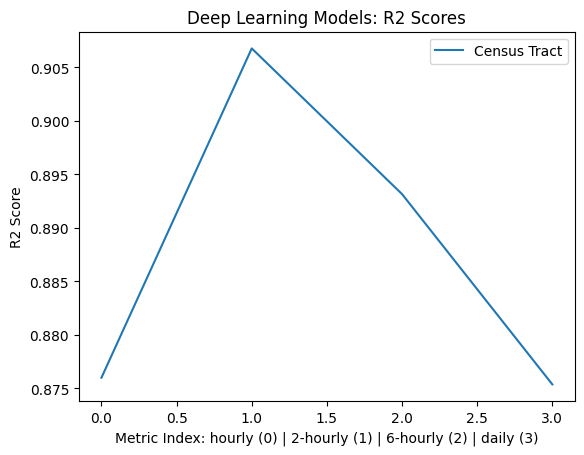

In [28]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the R2 scores for different models
ax.plot(dl_metrics_ct, label='Census Tract')

# Set labels and title
ax.set_xlabel('Metric Index: hourly (0) | 2-hourly (1) | 6-hourly (2) | daily (3)')
ax.set_ylabel('R2 Score')
ax.set_title('Deep Learning Models: R2 Scores')
ax.legend()

# Show the plot
plt.show()


The results will be discussed in detail in the report.
